In [1]:
import sys, os, glob, warnings, logging
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sw_plotting import change_bar_width
from sw_utilities import tukeyTest

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures

mkdir: ../jupyter_figures: File exists


In [2]:
df = pd.read_csv('../data/SMG-E-cad-K14_RFP-correlation-measurements/E-cad-IF-for-quantification-Ecad-quantification-Summary-6353.txt')
df1 = df
df = pd.read_csv('../data/SMG-E-cad-K14_RFP-correlation-measurements/E-cad-IF-for-quantification-Ecad-quantification-Summary-High-Low-Low-Low.txt')
df2 = df

# Concatenate the 2 dataframes and reset the index
df = pd.concat([df1, df2])
df.reset_index(inplace=True)

# Add column to store the RFP mean of two cells
df['RFP_mean'] = (df.RFP_cell_1 + df.RFP_cell_2) / 2

# Normalize Ecad_peak_height and RFP_mean by 1000 gray values
df['Ecad_peak_height'] = df['Ecad_peak_height'] / 1000
df['RFP_mean'] = df['RFP_mean'] / 1000
df['RFP_cell_1'] = df['RFP_cell_1'] / 1000
df['RFP_cell_2'] = df['RFP_cell_2'] / 1000

# Check the header
df.head()

2021-03-24 12:17:50,628 - INFO - NumExpr defaulting to 8 threads.


,index,file_name,edge_category,id,Ecad_AUC,Ecad_peak_height,RFP_cell_1,RFP_cell_2,z_position,RFP_mean
0,0,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,1,4486.6595,0.869342,0.795802,0.808196,8,0.801999
1,1,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,2,6135.7440,1.221321,1.580289,1.475370,8,1.527829
2,2,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,3,6372.3150,0.754206,0.576654,0.607933,9,0.592294
3,3,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,4,2535.1898,0.859864,0.919950,0.743782,8,0.831866
4,4,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,5,3790.7785,0.862489,0.411583,0.411654,10,0.411618


390
243


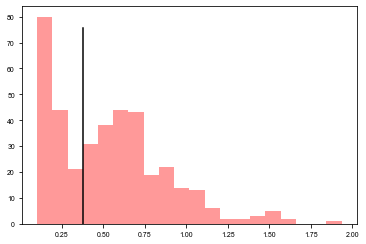

In [3]:
# Find the empirical RFP threshold value (high low boundary)
RFP = df.RFP_cell_1.tolist() + df.RFP_cell_2.tolist()
RFP_threshold = .380

sns.distplot(RFP, bins=20, kde=None, color='Red')
plt.axvline(RFP_threshold, 0, 0.9, c='k')
print(len(RFP))

# How many RFP is beyond the testing threshold?
a = [(RFP[i] > RFP_threshold) for i in range(len(RFP))]
print(a.count(True))

In [4]:
# Add data based category column
data_based_category = []

for i in range(len(df)):
    temp = 'High_Low'
    if df.RFP_cell_1[i] >= RFP_threshold and df.RFP_cell_2[i] >= RFP_threshold:
        temp = "High_High"
    if df.RFP_cell_1[i] < RFP_threshold and df.RFP_cell_2[i] < RFP_threshold:
        temp = "Low_Low"
    data_based_category.append(temp)

df['groups'] = data_based_category
df1_df2_combined = df
df.head()

,index,file_name,edge_category,id,Ecad_AUC,Ecad_peak_height,RFP_cell_1,RFP_cell_2,z_position,RFP_mean,groups
0,0,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,1,4486.6595,0.869342,0.795802,0.808196,8,0.801999,High_High
1,1,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,2,6135.7440,1.221321,1.580289,1.475370,8,1.527829,High_High
2,2,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,3,6372.3150,0.754206,0.576654,0.607933,9,0.592294,High_High
3,3,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,4,2535.1898,0.859864,0.919950,0.743782,8,0.831866,High_High
4,4,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,5,3790.7785,0.862489,0.411583,0.411654,10,0.411618,High_High


In [5]:
tukeyTest(df.Ecad_peak_height, df.groups)

Summary of test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1   group2  meandiff p-adj lower  upper  reject
------------------------------------------------------
High_High High_Low   0.4901 0.001 0.3117 0.6685   True
High_High  Low_Low   1.2292 0.001 1.0508 1.4076   True
 High_Low  Low_Low   0.7391 0.001 0.5335 0.9447   True
------------------------------------------------------
p values of all pair-wise tests:
 [0.001 0.001 0.001]


In [6]:
df.corr()

,index,id,Ecad_AUC,Ecad_peak_height,RFP_cell_1,RFP_cell_2,z_position,RFP_mean
index,1.000000,0.344566,0.035458,0.025051,0.104854,0.002130,0.286114,0.060073
id,0.344566,1.000000,0.072505,0.048408,-0.221091,0.020364,0.609279,-0.111846
Ecad_AUC,0.035458,0.072505,1.000000,0.863316,-0.450796,-0.451964,-0.268178,-0.522318
Ecad_peak_height,0.025051,0.048408,0.863316,1.000000,-0.465613,-0.546795,-0.290992,-0.587176
RFP_cell_1,0.104854,-0.221091,-0.450796,-0.465613,1.000000,0.493278,0.038507,0.854951
RFP_cell_2,0.002130,0.020364,-0.451964,-0.546795,0.493278,1.000000,0.068052,0.872939
z_position,0.286114,0.609279,-0.268178,-0.290992,0.038507,0.068052,1.000000,0.062175
RFP_mean,0.060073,-0.111846,-0.522318,-0.587176,0.854951,0.872939,0.062175,1.000000


<AxesSubplot:xlabel='RFP_mean', ylabel='Ecad_peak_height'>

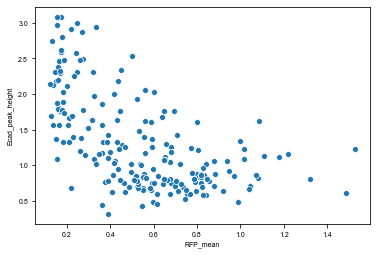

In [7]:
sns.scatterplot(df.RFP_mean, df.Ecad_peak_height)
# sns.scatterplot(data=df, x="RFP_mean", y="Ecad_peak_height", hue="file_name")

In [8]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df.RFP_mean, df.Ecad_peak_height)

print("Linear regression parameters (slope, intercep, r square, p_value and std_err):")
print(slope, intercept, r_value**2, p_value, std_err)

Linear regression parameters (slope, intercep, r square, p_value and std_err):
-1.339977697320219 2.0294296027193264 0.3447752547973159 1.850796468947113e-19 0.13296765717121736


In [9]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df.z_position, df.RFP_mean)

print("Linear regression parameters (slope, intercep, r square, p_value and std_err):")
print(slope, intercept, r_value**2, p_value, std_err)

Linear regression parameters (slope, intercep, r square, p_value and std_err):
0.0022091447500103075 0.4890615442831156 0.0038657306003001385 0.38787340875733367 0.0025526346880982874


<AxesSubplot:xlabel='groups', ylabel='Ecad_peak_height'>

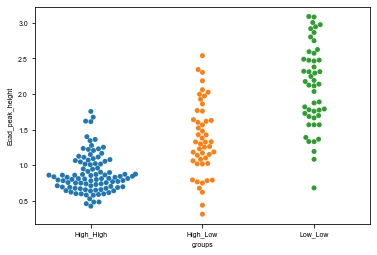

In [10]:
sns.swarmplot(df.groups, df.Ecad_peak_height)

In [11]:
a = list(df.edge_category == df.groups)
print( 'The total number of edges are: ', len(a))
print( 'The number of matched groups are: ', a.count(True) )

The total number of edges are:  195
The number of matched groups are:  183


In [12]:
# Adding measurements of the surface-derived cells
df = pd.read_csv('../data/SMG-E-cad-K14_RFP-correlation-measurements/E-cad-IF-for-quantification-Ecad-quantification-Summary-Surface-Derived-Cell-Edges.txt')

# Add column to store the RFP mean of two cells
df['RFP_mean'] = (df.RFP_cell_1 + df.RFP_cell_2) / 2

# Normalize Ecad_peak_height and RFP_mean by 1000 gray values
df['Ecad_peak_height'] = df['Ecad_peak_height'] / 1000
df['RFP_mean'] = df['RFP_mean'] / 1000
df['RFP_cell_1'] = df['RFP_cell_1'] / 1000
df['RFP_cell_2'] = df['RFP_cell_2'] / 1000

# Add data based category column
data_based_category = []
for i in range(len(df)):
    temp = 'High_Low_SD'
    if df.RFP_cell_1[i] >= RFP_threshold and df.RFP_cell_2[i] >= RFP_threshold:
        temp = "High_High_SD"
    if df.RFP_cell_1[i] < RFP_threshold and df.RFP_cell_2[i] < RFP_threshold:
        temp = "Low_Low_SD"
    data_based_category.append(temp)

df['groups'] = data_based_category

df3 = df
df3.head()

,file_name,edge_category,id,Ecad_AUC,Ecad_peak_height,RFP_cell_1,RFP_cell_2,z_position,RFP_mean,groups
0,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_Low,1,6255.2470,1.003793,1.159715,0.139382,14,0.649548,High_Low_SD
1,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_Low,2,6638.3349,1.140797,1.025197,0.191043,35,0.608120,High_Low_SD
2,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_Low,3,5029.8314,1.127809,1.104968,0.146003,27,0.625486,High_Low_SD
3,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_Low,4,7238.6611,0.888208,0.888280,0.544572,17,0.716426,High_High_SD
4,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_Low,5,8542.9606,1.944409,0.425675,0.118761,11,0.272218,High_Low_SD


In [13]:
# Concatenate the 2 dataframes and reset the index
df = pd.concat([df1_df2_combined, df3])
df.reset_index(inplace=True)
df_all = df
df.head()

,level_0,index,file_name,edge_category,id,Ecad_AUC,Ecad_peak_height,RFP_cell_1,RFP_cell_2,z_position,RFP_mean,groups
0,0,0.0,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,1,4486.6595,0.869342,0.795802,0.808196,8,0.801999,High_High
1,1,1.0,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,2,6135.7440,1.221321,1.580289,1.475370,8,1.527829,High_High
2,2,2.0,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,3,6372.3150,0.754206,0.576654,0.607933,9,0.592294,High_High
3,3,3.0,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,4,2535.1898,0.859864,0.919950,0.743782,8,0.831866,High_High
4,4,4.0,SMG2-2-FOV1-60x-retake-1024-3-rotated,High_High,5,3790.7785,0.862489,0.411583,0.411654,10,0.411618,High_High


<AxesSubplot:xlabel='groups', ylabel='Ecad_peak_height'>

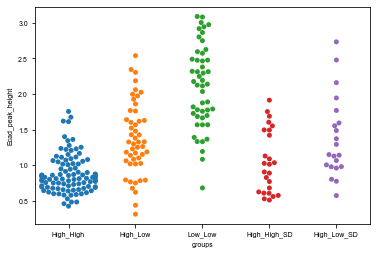

In [14]:
sns.swarmplot(df.groups, df.Ecad_peak_height,
              order=['High_High', 'High_Low', 'Low_Low', 'High_High_SD', 'High_Low_SD'])

In [15]:
tukeyTest(df.Ecad_peak_height, df.groups)

Summary of test:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
   High_High High_High_SD   0.1719  0.425 -0.1027 0.4464  False
   High_High     High_Low   0.4901  0.001  0.2755 0.7047   True
   High_High  High_Low_SD   0.4983  0.001  0.2036 0.7929   True
   High_High      Low_Low   1.2292  0.001  1.0146 1.4438   True
High_High_SD     High_Low   0.3182 0.0323  0.0174 0.6191   True
High_High_SD  High_Low_SD   0.3264 0.0995 -0.0359 0.6888  False
High_High_SD      Low_Low   1.0573  0.001  0.7565 1.3582   True
    High_Low  High_Low_SD   0.0082    0.9 -0.3111 0.3275  False
    High_Low      Low_Low   0.7391  0.001  0.4918 0.9864   True
 High_Low_SD      Low_Low   0.7309  0.001  0.4116 1.0502   True
---------------------------------------------------------------
p values of all pair-wise tests:
 [0.42499627 0.001      0.001      0.001      0.03226

## Plots for figures

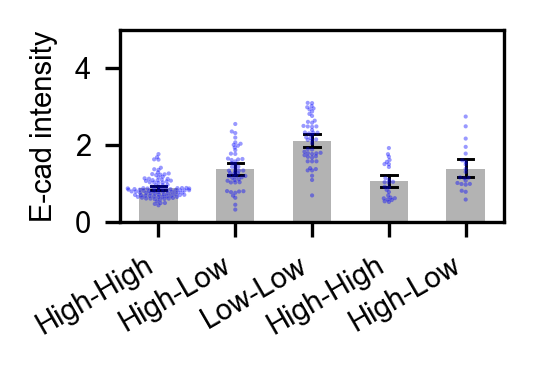

In [16]:
# Swarm plot of 5 categories

outputPrefix = '20200916-24-SMG-Krt14-RFP-Ecad-correlation-swarm'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width=1.6
fig_height=0.8
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(x='groups', y='Ecad_peak_height', data=df,
                   order=['High_High', 'High_Low', 'Low_Low', 'High_High_SD', 'High_Low_SD'],
                   color="blue", size=1.0, alpha=.4)

ax = sns.barplot(x='groups', y='Ecad_peak_height', data=df,
                 color=".7", alpha=1.0,
                 order=['High_High', 'High_Low', 'Low_Low', 'High_High_SD', 'High_Low_SD'],
                 errwidth=.7, errcolor="k", capsize=.2, ci=95)

plt.ylim(0, 5)
# plt.yticks([0, 10, 20])

plt.xlabel(None)
plt.ylabel("E-cad intensity")

# ax.set_xticklabels(labels=plot_order, rotation=45, ha="right")

# make the bar width narrower
change_bar_width(ax, .5)

# rotate x tick labels
x_labels = ['High-High', 'High-Low', 'Low-Low', 'High-High', 'High-Low']
ax.set_xticklabels(labels=x_labels, rotation=30, ha="right")

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


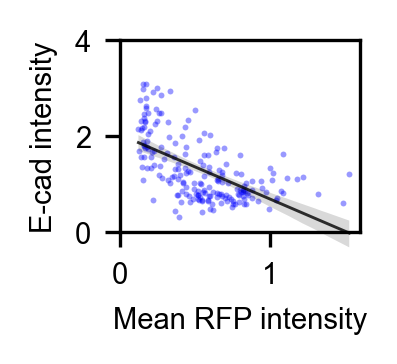

In [17]:
# Regression plot of E-cad and mean RFP intensities

outputPrefix = '20200916-24-SMG-Krt14-RFP-Ecad-correlation-regplot'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width=1.0
fig_height=0.8
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.regplot(data = df1_df2_combined, x = 'RFP_mean', y = 'Ecad_peak_height',
                 scatter_kws={'s': 2, 'color': 'b', 'alpha': .4, 'linewidth': 0},
                 line_kws={'color': 'k', 'alpha': .8, 'linewidth': .7},
                )

plt.ylim(0, 4)
# plt.yticks([0, 10, 20])
plt.xlim(0, 1.6)

plt.xlabel('Mean RFP intensity')
plt.ylabel("E-cad intensity")

# ax.set_xticklabels(labels=plot_order, rotation=45, ha="right")

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


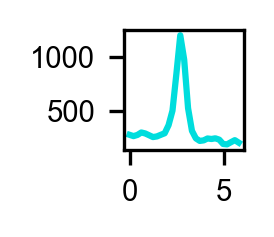

In [18]:
# Example Ecad linescan profile

df_ecad_example = pd.read_csv('../data/SMG-E-cad-K14_RFP-correlation-measurements/Example-Ecad-linescan.csv',
                              header=None) 

df_ecad_example.columns = ['microns', 'Ecad']
df_ecad_example

outputPrefix = '20200916-24-SMG-Krt14-RFP-Ecad-correlation-example-line-profile'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width=0.5
fig_height=0.5
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

plt.plot(df_ecad_example.microns, df_ecad_example.Ecad, color='#00dddd')

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


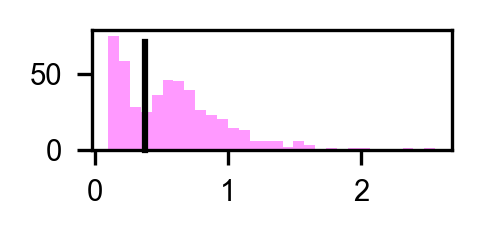

In [19]:
outputPrefix = '20200916-24-SMG-Krt14-RFP-Ecad-correlation-RFP-histogram'
# outputFigPath = None
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width = 1.5
fig_height = 0.5
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Find the empirical RFP threshold value (high low boundary)
RFP = df.RFP_cell_1.tolist() + df.RFP_cell_2.tolist()
RFP_threshold = .380

sns.distplot(RFP, bins=30, kde=None, color='Magenta')
plt.axvline(RFP_threshold, 0, 0.9, c='k')

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)
